In [4]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
from specim.specfuncs import spec1d
import numpy as np
import matplotlib.pyplot as plt
import glob
from random import sample
import pandas as pd
import seaborn as sn
import pm_veldis_util as vd
from collections import Counter

In [5]:
data =  spec1d.Spec1d('../galaxy_spectra/J0659gal.txt')
lamda_galaxy = data['wav']
spectra_galaxy = data['flux']
variance_spectra_galaxy = data['var']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]


Reading spectrum from ../galaxy_spectra/J0659gal.txt
Expected file format: text
 Spectrum Start:  5592.31
 Spectrum End:     7244.38
 Dispersion (1st pixel):   0.40
 Dispersion (average):      0.40



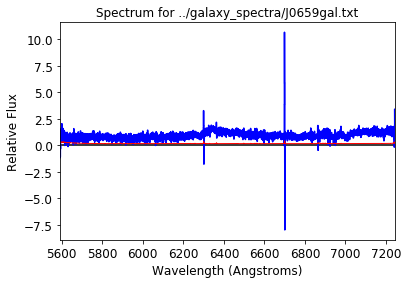

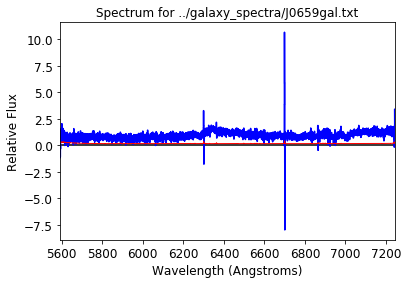

In [6]:
data.plot()
#data.mark_lines('abs', z=0.7666)


Line        lambda_rest  lambda_obs
----------  -----------  -----------
H-kappa       3750.00       6624.00
[Fe VII]      3761.40       6644.14
H-iota        3770.00       6659.33
H-theta       3797.00       6707.02
H-eta         3835.00       6774.14
CN bandhd     3883.00       6858.93
CaII K        3933.67       6948.43
CaII H        3968.47       7009.91
H-delta       4101.00       7244.01



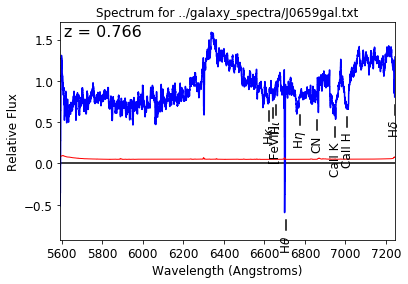

In [7]:
data.smooth(11)
data.mark_lines('abs', z=0.7664, usesmooth=True)
#plt.figure()
#data.smooth(9)
#data.mark_lines('abs', z=0.7666, usesmooth=True)

### Checking whether the wavelength range of the tamplate spectra from the Indo-US library covers the galaxy spectra given the redshift. Here we can see the for the redshift, z=0.767 template spectra cover from $6122$ to $16731 Ang.$ So we should use only the part of the galaxy spectra where wavelength is bigger than $6122 Ang.$

In [8]:
z = 0.767
lam_temp_ini = 3465.0       
lam_temp_fin = 9469.00
lam_range_min = lam_temp_ini*(1+z)
lam_range_max = lam_temp_fin*(1+z)
print(lam_range_min)
print(lam_range_max)

6122.655
16731.722999999998


[6541.2, 7244.38]

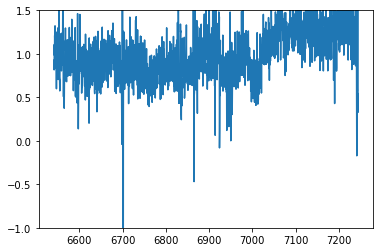

In [12]:
lamda_galaxy = data['wav'][2343:]
spectra_galaxy = data['flux'][2343:]
variance_spectra_galaxy = data['var'][2343:]
sky_spectra_galaxy = data['sky'][2343:]
lamda_galaxy_range =  [lamda_galaxy[0], lamda_galaxy[-1]]
#lamda_galaxy [2343]
plt.plot(lamda_galaxy, spectra_galaxy)
plt.ylim(-1.0, 1.5)
lamda_galaxy_range

Velocity scale = 18.790292 km/s
dv = -190490.526823 


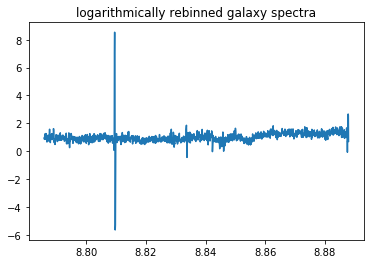

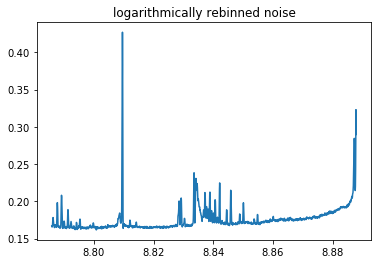


As no 'fwhm_temp' value is provided, FWHM for the Indo-US templatelibrary will be used as default value


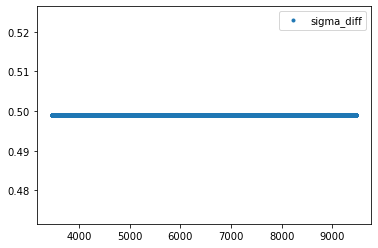

In [38]:
# Calulating velocity scale

velocity_scale = vd.velocity_scale(lamda_galaxy)

# Calculating the parameter 'dv'

dv = vd.wav_dev(lamda_galaxy[0])

# Initial guess for velocity and velocity dispersion

c = 299792.458
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  

# Logarithmically rebinning the galaxy spectra

median_spectra_gal = np.median(spectra_galaxy)       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
spectra_galaxy_rebinned, log_lamda_galaxy = util.log_rebin(lamda_galaxy_range, spectra_galaxy_normalized, 
                                                         velscale=velocity_scale)[:2]
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)
plt.title('logarithmically rebinned galaxy spectra')
plt.show()

## Noise

sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
noise = sigma_galaxy_spectra / median_spectra_gal

noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range, noise,
                                                          velscale=velocity_scale)

plt.plot(log_lamda_noise, noise_rebinned)
plt.title('logarithmically rebinned noise')
plt.show()
#print(velo_scale)
#print(np.size(noise_new))


# Calculating the difference in sigma between the instrumental LSF of the galaxy spectra and templates.
# Here sigma of the instrument, 'sig_ins', has been obtained by performing Gaussian fit with several emission 
# lines from the galaxy spectra.

sigma_diff = vd.gen_sigma_diff(sig_ins=0.76, lam_gal=lamda_galaxy)



In [19]:
mask_region = [(8.8084, 8.8106), (8.8869, 8.8879)]
#mask_region = [(8.8084, 8.8106), (8.8873, 8.8879)]
#mask_region = [(8.8084, 8.8106), (8.8800, 8.8879)]

In [40]:
templates = vd.gen_rebinned_templates(lib_path='../TEXT/*', temp_num=800, sigma_diff=sigma_diff,
                                      v=velocity_scale)

In [ ]:
sky_spectra_normalized = sky_spectra_galaxy / np.median(sky_spectra_galaxy)
sky_spectra_rebinned, log_lamda_sky, v = util.log_rebin(lamda_galaxy_range, sky_spectra_normalized, 
                                                         velscale=velocity_scale)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    170248       266    -0.030     0.027
chi2/DOF: 1.068
method = capfit; Jac calls: 6; Func calls: 36; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  12 / 800
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    170254       265    -0.020     0.026
chi2/DOF: 1.068
method = capfit; Jac calls: 7; Func calls: 40; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  12 / 800


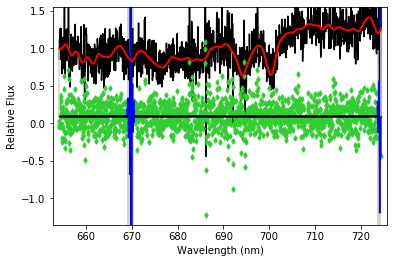

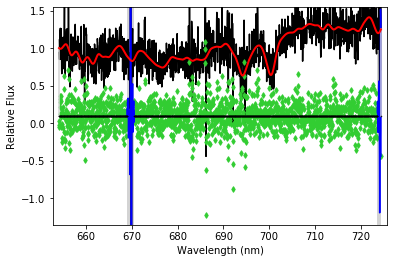

<Figure size 432x288 with 0 Axes>

In [42]:
mask = vd.masking(mask_region, log_lamda_galaxy)
degree = np.arange(6,8)
velocity_dispersion = np.zeros(len(degree))
for i, d in enumerate(degree):
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
            plot=True, vsyst=dv, degree=d, mask=mask, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1] 
    #plt.savefig('ppxf_fit_J0659.pdf', dpi=300)
    plt.figure()

In [ ]:
mask = vd.masking(mask_region, log_lamda_galaxy)
degree = np.arange(6,8)
velocity_dispersion = np.zeros(len(degree))
for i, d in enumerate(degree):
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
            plot=True, vsyst=dv, degree=d, mask=mask, lam=np.exp(log_lamda_galaxy),
            sky=sky_spectra_rebinned)
    velocity_dispersion[i] = pp.sol[1] 
    plt.savefig('ppxf_fit_J0659.pdf', dpi=300)
    plt.figure()

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.savefig('vel_dis.pdf', dpi=300)


In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()

In [ ]:
#mask = vd.masking(mask_region, log_lamda_galaxy)
degree = np.arange(4,20)
velocity_dispersion = np.zeros(len(degree))
for i, d in enumerate(degree):
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
            plot=True, vsyst=dv, degree=d, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1] 
    plt.figure()

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()

In [ ]:
mask = vd.masking(mask_region, log_lamda_galaxy)
degree = np.arange(4,20)
velocity_dispersion = np.zeros(len(degree))
error = np.zeros(len(degree))
for i, d in enumerate(degree):
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
            plot=True, vsyst=dv, degree=d, mask=mask, lam=np.exp(log_lamda_galaxy),
            sky=sky_spectra_rebinned)
    velocity_dispersion[i] = pp.sol[1] 
    error[i] = pp.error[1]
    plt.figure()

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()

In [ ]:
plt.plot(degree, error, '.')
plt.xlabel('degree')
plt.ylabel('error')
plt.figure()

In [ ]:
len(log_lamda_galaxy)

In [ ]:
len(np.log(lamda_galaxy))

In [ ]:
np.shape(spectra_galaxy_rebinned)

In [ ]:
lamda_galaxy[0]

In [1]:
from veldis.veldis import Veldis

In [2]:
spec1 = Veldis('../galaxy_spectra/J0659gal.txt')


Reading spectrum from ../galaxy_spectra/J0659gal.txt
Expected file format: text
 Spectrum Start:  5592.31
 Spectrum End:     7244.38
 Dispersion (1st pixel):   0.40
 Dispersion (average):      0.40




Line        lambda_rest  lambda_obs
----------  -----------  -----------
H-kappa       3750.00       6624.00
[Fe VII]      3761.40       6644.14
H-iota        3770.00       6659.33
H-theta       3797.00       6707.02
H-eta         3835.00       6774.14
CN bandhd     3883.00       6858.93
CaII K        3933.67       6948.43
CaII H        3968.47       7009.91
H-delta       4101.00       7244.01



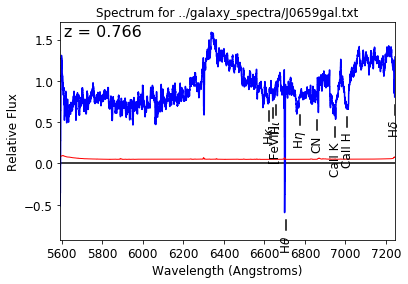

In [3]:
spec1.smooth(11)
spec1.mark_lines('abs', z=0.7664, usesmooth=True)

In [10]:
spec1.check_temp_coverage(intemp='../TEXT/100006.txt', z=.767)


Covered range for redshift 0.767000 : 6122.655000 - 16731.723000



spectra has been trimed, now...

wav_min : 6541.200000

wav_max : 7244.380000
 Spectrum Start:  6541.20
 Spectrum End:     7244.38
 Dispersion (1st pixel):   0.41
 Dispersion (average):      0.40





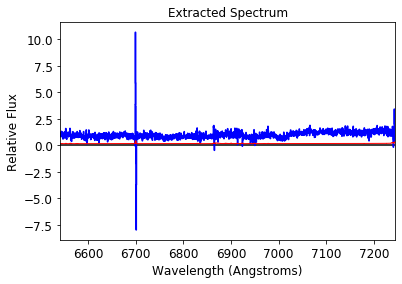

In [13]:
spec1.trimspec(wavrange=[6541.2, 7244.38])

Velocity scale = 18.790292 km/s


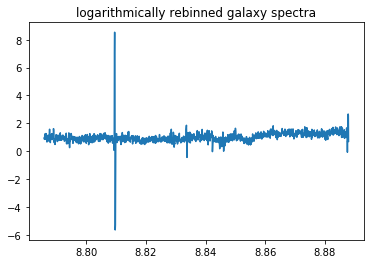

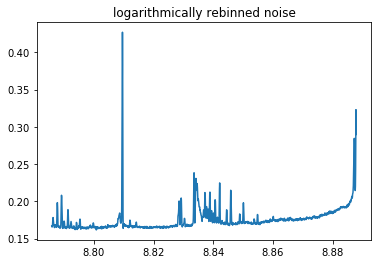

In [16]:
flux_r, noi_r, st = spec1.cal_parm(z=0.767)

dv = -190490.526823 

As no 'fwhm_temp' value is provided, FWHM for the Indo-US template library will be used as default value


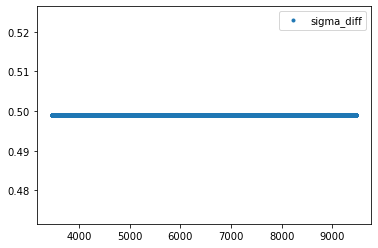

In [41]:
temp_spec = spec1.gen_rebinned_temp(lib_path='../TEXT/*', temp_num=800, sig_ins=0.76)

In [44]:
np.max(temp_spec - templates)

0.0

In [21]:
mask_s = spec1.masking(pixel_range=mask_region)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    170248       266    -0.030     0.027
chi2/DOF: 1.068
method = capfit; Jac calls: 6; Func calls: 36; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  12 / 800
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    170254       265    -0.020     0.026
chi2/DOF: 1.068
method = capfit; Jac calls: 7; Func calls: 40; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  12 / 800


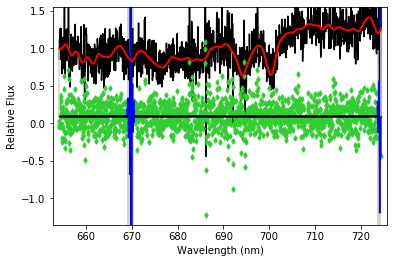

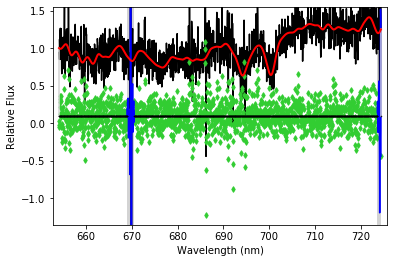

<Figure size 432x288 with 0 Axes>

In [45]:
dv1 = -190490.526823 
degree = np.arange(6,8)
velocity_dispersion = np.zeros(len(degree))
for i, d in enumerate(degree):
    pp = ppxf(temp_spec, flux_r, noi_r, spec1.v, st, moments=4,
            plot=True, vsyst=dv1, degree=d, mask=mask_s, lam=np.exp(spec1.wav_rebinned))
    plt.figure()

In [37]:
np.min(noi_r - noise_rebinned)

0.0